### Connect Drive

🧩 Part 1: Setup – Import Libraries and Mount Google Drive


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

!pip install git+https://github.com/vanvalenlab/cellSAM.git
!pip install scikit-image matplotlib

import os
import numpy as np
import torch
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image

from skimage import io
from skimage.color import rgb2gray

from cellSAM import segment_cellular_image

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Mounted at /content/drive
  Cloning https://github.com/vanvalenlab/cellSAM.git to /tmp/pip-req-build-d0khhwds
  Running command git clone --filter=blob:none --quiet https://github.com/vanvalenlab/cellSAM.git /tmp/pip-req-build-d0khhwds
  Resolved https://github.com/vanvalenlab/cellSAM.git to commit b7ece01ca2a3b6110dc459ce28605fc3b84a3d1d
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-install-5tqs00oq/segment-anything_209b80bd14ed4fae9592da1434c1f3d0
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-install-5tqs00oq/segment-anything_209b80bd14ed4fae9592da1434c1f3d0
  Resolved https://github.com/facebookresearch/segment-anything.git to commit dca509fe793f601edb92606367a655c15ac00fdf
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━

ModuleNotFoundError: No module named 'cellSAM'

🧩 Part 2: Define Paths for Images and Output Masks


In [ ]:
# Path to the input stained images for segmentation
images_dir = '/content/drive/MyDrive/final project/Part 3 - Cell Segmentation with Transfer Learning/data/stained images'

# Path to save the output masks predicted by CellSAM
masks_dir = '/content/drive/MyDrive/final project/Part 3 - Cell Segmentation with Transfer Learning/data/cellsam_predicted_mask'

# Create the output directory if it doesn't exist
os.makedirs(masks_dir, exist_ok=True)



🧩 Step 3: Define Window Parameters and Helper Functions
python
Copy
Edit


In [ ]:
# Define window size and overlap for image tiling
window_shape = (512, 512)
overlap = 0.5

# Split a large image into overlapping patches
def split_image(img, window_shape, overlap):
    step_size = tuple(int(w * (1 - overlap)) for w in window_shape)
    num_windows_x = (img.shape[1] - window_shape[1]) // step_size[1] + 1
    num_windows_y = (img.shape[0] - window_shape[0]) // step_size[0] + 1
    x_start = [i * step_size[1] for i in range(num_windows_x)]
    y_start = [i * step_size[0] for i in range(num_windows_y)]

    windows = []
    for y in y_start:
        for x in x_start:
            window = img[y:y + window_shape[0], x:x + window_shape[1]]
            windows.append(window)
    return windows, num_windows_x, num_windows_y

# Reconstruct the full image from overlapping patches
def join_images(windows, image_shape, window_shape, overlap):
    step_size = tuple(int(w * (1 - overlap)) for w in window_shape)
    num_windows_x = (image_shape[1] - window_shape[1]) // step_size[1] + 1
    num_windows_y = (image_shape[0] - window_shape[0]) // step_size[0] + 1
    x_start = [i * step_size[1] for i in range(num_windows_x)]
    y_start = [i * step_size[0] for i in range(num_windows_y)]

    result = np.zeros(image_shape, dtype=windows[0].dtype)
    window_index = 0
    for y in y_start:
        for x in x_start:
            result[y:y + window_shape[0], x:x + window_shape[1]] = windows[window_index]
            window_index += 1
    return result


🧩 Step 4: Define Function to Run CellSAM on a Single Image
python
Copy
Edit


In [ ]:
def run_cellsam_on_image(image_path, save=True, plot=False, return_count=True):
    import time
    img = io.imread(image_path)

    if len(img.shape) == 3:
        img = rgb2gray(img)

    windows, _, _ = split_image(img, window_shape, overlap)
    total_windows = len(windows)
    start_time = time.time()

    label_offset = 0
    results = []

    for i, window in enumerate(windows):
        print(f"\n🟦 Patch {i+1}/{total_windows}")

        try:
            mask, _, _ = segment_cellular_image(window, device=str(device))

            if mask is None or not hasattr(mask, 'ndim') or mask.max() == 0:
                raise ValueError("Empty or invalid mask")

            mask[mask > 0] += label_offset
            label_offset = mask.max()
            results.append(mask)

        except Exception as e:
            print(f"⚠️ Window {i+1} failed: {e}")
            results.append(np.zeros_like(window, dtype=np.uint16))

        # Accumulated time
        elapsed_time = time.time() - start_time
        formatted_time = time.strftime("%H:%M:%S", time.gmtime(elapsed_time))
        print(f"⏱️ Accumulated time: {formatted_time}")

    # Join windows into full mask
    full_mask = join_images(results, img.shape, window_shape, overlap)

    # Save mask (uint16)
    save_path = None
    if save:
        save_path = image_path.replace('stained images', 'cellsam_predicted_mask').replace('.tif', '_mask.tif')
        Image.fromarray(full_mask.astype(np.uint16)).save(save_path, format='TIFF')
        print(f"💾 Saved mask to: {save_path}")

    # Plot result
    if plot:
        plt.figure(figsize=(6,6))
        plt.imshow(full_mask, cmap='nipy_spectral')
        plt.title("CellSAM Segmentation Mask")
        plt.axis('off')
        plt.show()

    # Count cells
    count = None
    if return_count:
        count, _ = cv2.connectedComponents((full_mask > 0).astype(np.uint8))

    return full_mask, save_path, (count - 1 if count is not None else None)


🧩 Step 5: Run CellSAM on a Single Image and Display the Result
python
Copy
Edit



🟦 Patch 1/70
⏱️ Accumulated time: 00:00:04

🟦 Patch 2/70
⏱️ Accumulated time: 00:00:07

🟦 Patch 3/70
⏱️ Accumulated time: 00:00:10

🟦 Patch 4/70
⏱️ Accumulated time: 00:00:13

🟦 Patch 5/70
⏱️ Accumulated time: 00:00:17

🟦 Patch 6/70
⏱️ Accumulated time: 00:00:20

🟦 Patch 7/70
⏱️ Accumulated time: 00:00:23

🟦 Patch 8/70
⏱️ Accumulated time: 00:00:26

🟦 Patch 9/70
⏱️ Accumulated time: 00:00:30

🟦 Patch 10/70
⏱️ Accumulated time: 00:00:33

🟦 Patch 11/70
⏱️ Accumulated time: 00:00:36

🟦 Patch 12/70
⏱️ Accumulated time: 00:00:39

🟦 Patch 13/70
⏱️ Accumulated time: 00:00:43

🟦 Patch 14/70
⏱️ Accumulated time: 00:00:47

🟦 Patch 15/70
⏱️ Accumulated time: 00:00:50

🟦 Patch 16/70
⏱️ Accumulated time: 00:00:54

🟦 Patch 17/70
⏱️ Accumulated time: 00:00:58

🟦 Patch 18/70
⏱️ Accumulated time: 00:01:01

🟦 Patch 19/70
⏱️ Accumulated time: 00:01:05

🟦 Patch 20/70
⏱️ Accumulated time: 00:01:09

🟦 Patch 21/70
⏱️ Accumulated time: 00:01:12

🟦 Patch 22/70
⏱️ Accumulated time: 00:01:16

🟦 Patch 23/70
⏱️ A

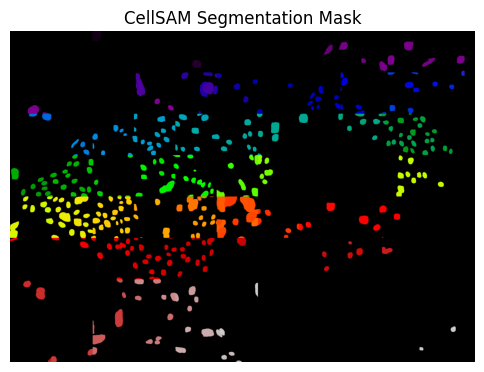

✅ Segmentation completed
📁 Saved to: /content/drive/MyDrive/final project/Part 2 - cell segmentation with cellSAM/p63_mask.png
🔢 Number of cells detected: 324


In [ ]:
# Path to the test image
image_path = '/content/drive/MyDrive/final project/Part 2 - cell segmentation with cellSAM/p63.tif'

# Run segmentation and save mask
mask, save_path, cell_count = run_cellsam_on_image(image_path, save=True, plot=True, return_count=True)

# Display basic summary
print(f"✅ Segmentation completed")
print(f"📁 Saved to: {save_path}")
print(f"🔢 Number of cells detected: {cell_count}")


🧩 Step 6: Segment All Images and Count Cells
python
Copy
Edit


In [ ]:
import time

cell_counts = {}
image_files = sorted(os.listdir(images_dir))

for idx, filename in enumerate(image_files):
    image_path = os.path.join(images_dir, filename)
    print(f"\n📂 [{idx+1}/{len(image_files)}] Starting: {filename}")
    start_time = time.time()

    try:
        mask, save_path, count = run_cellsam_on_image(image_path, save=True, plot=False, return_count=True)
        cell_counts[filename] = count

        elapsed = time.time() - start_time
        formatted = time.strftime("%H:%M:%S", time.gmtime(elapsed))
        print(f"✅ Finished {filename}: {count} cells — Time: {formatted}")

    except Exception as e:
        print(f"❌ Failed on {filename}: {e}")



📂 [1/5] Starting: p63_1.tif

🟦 Patch 1/70
⏱️ Accumulated time: 00:00:03

🟦 Patch 2/70
⏱️ Accumulated time: 00:00:06

🟦 Patch 3/70
⏱️ Accumulated time: 00:00:09

🟦 Patch 4/70
⏱️ Accumulated time: 00:00:13

🟦 Patch 5/70
⏱️ Accumulated time: 00:00:16

🟦 Patch 6/70
⏱️ Accumulated time: 00:00:19

🟦 Patch 7/70
⏱️ Accumulated time: 00:00:23

🟦 Patch 8/70
⏱️ Accumulated time: 00:00:27

🟦 Patch 9/70
⏱️ Accumulated time: 00:00:30

🟦 Patch 10/70
⏱️ Accumulated time: 00:00:33

🟦 Patch 11/70
⏱️ Accumulated time: 00:00:36

🟦 Patch 12/70
⏱️ Accumulated time: 00:00:40

🟦 Patch 13/70
⏱️ Accumulated time: 00:00:43

🟦 Patch 14/70
⏱️ Accumulated time: 00:00:47

🟦 Patch 15/70
⏱️ Accumulated time: 00:00:50

🟦 Patch 16/70
⏱️ Accumulated time: 00:00:55

🟦 Patch 17/70
⏱️ Accumulated time: 00:00:58

🟦 Patch 18/70
⏱️ Accumulated time: 00:01:01

🟦 Patch 19/70
⏱️ Accumulated time: 00:01:04

🟦 Patch 20/70
⏱️ Accumulated time: 00:01:07

🟦 Patch 21/70
⏱️ Accumulated time: 00:01:11

🟦 Patch 22/70
⏱️ Accumulated time:

🧩 Step 7: Build Ground Truth Table from Cell Counts
python
Copy
Edit


In [ ]:
import pandas as pd

# Convert the cell_counts dictionary to a DataFrame
gt_df = pd.DataFrame(list(cell_counts.items()), columns=['filename', 'cell_count'])

# Preview the table
print("📊 Ground Truth Table:")
display(gt_df.head())

# Save as CSV to your Drive
gt_df.to_csv('/content/drive/MyDrive/final project/cell_counts_table.csv', index=False)
print("💾 Saved to: cell_counts_table.csv")


📊 Ground Truth Table:


,filename,cell_count
0,p63_1.tif,206
1,p63_2.tif,266
2,p63_3.tif,416
3,p63_4.tif,328
4,p63_5.tif,324


💾 Saved to: cell_counts_table.csv


🧩 Part 8: Visualize All Images and Corresponding Masks
python
Copied
Edit



In [ ]:
from skimage.io import imread
from skimage.color import rgb2gray
import matplotlib.pyplot as plt
import os
import numpy as np

# Define paths
image_dir = '/content/drive/MyDrive/final project/Part 3 - Cell Segmentation with Transfer Learning/data/stained images'
mask_dir  = '/content/drive/MyDrive/final project/Part 3 - Cell Segmentation with Transfer Learning/data/cellsam_predicted_mask'
image_files = sorted(os.listdir(image_dir))

# -------- 1. Side-by-side display --------
print("🔹 Displaying images and masks side-by-side")
for filename in image_files:
    if not filename.endswith('.tif'):
        continue

    image_path = os.path.join(image_dir, filename)
    mask_name = filename.replace('.tif', '_mask.tif')
    mask_path = os.path.join(mask_dir, mask_name)

    image = imread(image_path)
    if image.ndim == 3:
        image = rgb2gray(image)
    mask = imread(mask_path)

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(image, cmap='gray')
    plt.title(f"Original: {filename}")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(mask, cmap='nipy_spectral')
    plt.title(f"Mask: {mask_name}")
    plt.axis('off')

    plt.tight_layout()
    plt.show()

# -------- 2. Overlay display --------
print("🔹 Displaying overlay of masks on images")
for filename in image_files:
    if not filename.endswith('.tif'):
        continue

    image_path = os.path.join(image_dir, filename)
    mask_name = filename.replace('.tif', '_mask.tif')
    mask_path = os.path.join(mask_dir, mask_name)

    image = imread(image_path)
    if image.ndim == 3:
        image = rgb2gray(image)
    mask = imread(mask_path)

    plt.figure(figsize=(6, 6))
    plt.imshow(image, cmap='gray')
    plt.imshow(mask, cmap='nipy_spectral', alpha=0.4)  # Overlay with transparency
    plt.title(f"Overlay: {filename}")
    plt.axis('off')
    plt.tight_layout()
    plt.show()


#Prediction Part


### 🧩 Part 0: Loading Ground Truth Cell Counts from CSV


In [ ]:
# 🧩 Setup – Mount Drive and Import Essentials
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os

import numpy as np
import torch
import pandas as pd
from PIL import Image
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from torchvision.models import resnet18
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# 🧩 Define paths
original_dir = '/content/drive/MyDrive/final project/Part 3 - Cell Segmentation with Transfer Learning/data/original_images'
mask_dir     = '/content/drive/MyDrive/final project/Part 3 - Cell Segmentation with Transfer Learning/data/cellsam_predicted_mask'
csv_path     = '/content/drive/MyDrive/final project/cell_counts_table.csv'

# 🧩 Load ground truth from CSV
gt_df = pd.read_csv(csv_path)
cell_counts = dict(zip(gt_df['filename'], gt_df['cell_count']))
print(f"✅ Loaded {len(cell_counts)} cell count entries from CSV.")
gt_df

Using device: cuda
✅ Loaded 5 cell count entries from CSV.


,filename,cell_count
0,p63_1.tif,206
1,p63_2.tif,266
2,p63_3.tif,416
3,p63_4.tif,328
4,p63_5.tif,324


### Part 1–2: Load Original Images and Match with GT Cell Counts


In [ ]:
from PIL import Image
import torchvision.transforms as transforms

# Path to original images
original_dir = '/content/drive/MyDrive/final project/Part 3 - Cell Segmentation with Transfer Learning/data/original_images'
original_files = sorted(os.listdir(original_dir))


# GT from previous step: dict of {basename: count}
gt_dict = {name: count for name, count in cell_counts.items()}

# Define transform (resize + tensor)
transform = transforms.Compose([
    transforms.Resize((256, 256)),  # options: 128 , 256 , 512
    transforms.RandomHorizontalFlip(p=0.5),  # Options: p=0.0, 0.5, 1.0
    transforms.RandomRotation(15),  # Options: 0, 10, 15, 30
    transforms.ColorJitter(brightness=0.2, contrast=0.2),  # Options: 0.1, 0.2, 0.3
    transforms.ToTensor()
])




# Build dataset as list of (image, target)
image_targets = []
for filename in original_files:
    path = os.path.join(original_dir, filename)
    image = Image.open(path).convert("RGB")
    image = transform(image)

    count = gt_dict.get(filename, 0)
    image_targets.append((image, torch.tensor([count], dtype=torch.float)))
# הצג התאמה אחת לבדיקה
for name, count in gt_dict.items():
    print(f"{name} → {count} cells")
    break


p63_1.tif → 206 cells


### Part 3: Build Dataset and DataLoader for Regression


In [ ]:
from torch.utils.data import Dataset, DataLoader

# Define Dataset class for regression
class CellCountDataset(Dataset):
    def __init__(self, data):
        self.data = data  # list of (image, target)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image, target = self.data[idx]
        return image, target

# Create Dataset and DataLoader
batch_size = 5  # Options: 1, 2, 4, 5 (entire dataset)
regression_dataset = CellCountDataset(image_targets)
regression_dataloader = DataLoader(regression_dataset, batch_size=batch_size, shuffle=True)


### Part 4: Build a Simple CNN Model for Cell Count Regression


In [ ]:
import torch.nn as nn

class SimpleCNN(nn.Module):  # שומר על השם הקיים
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1,1))
        )
        dropout_rate = 0.3  # Options: 0.0, 0.1, 0.3, 0.5

        self.regressor = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(64, 1)
        )


    def forward(self, x):
        x = self.features(x)
        x = self.regressor(x)
        return x


# Part 4 - Resnet18 for cell count

In [ ]:
from torchvision.models import resnet18

# Define the model from scratch (no pretraining)
resnet_model = resnet18(pretrained=False)

dropout_rate = 0.3  # Options: 0.0, 0.1, 0.2 0.3, 0.5

# Replace the classification head with a regression head + dropout
resnet_model.fc = nn.Sequential(
    nn.Dropout(dropout_rate),  # Defined earlier
    nn.Linear(resnet_model.fc.in_features, 1)
)

# Move model to GPU if available

# Optional: Freeze all layers except the final regression head
# for param in regression_model.parameters():
#     param.requires_grad = False
# for param in regression_model.fc.parameters():
#     param.requires_grad = True


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


### Part 5: Define Loss Function and Optimizer for Regression


In [ ]:
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau


#Choose model Resnet / Simple CNN
#regression_model = SimpleCNN().to(device)
regression_model = resnet_model.to(device)




# Define loss function and optimizer
regression_criterion = nn.MSELoss()  # Options: MSELoss, L1Loss, SmoothL1Loss

learning_rate = 5e-3  # Options: 5e-5, 1e-4, 1e-3, 5e-3
weight_decay = 1e-3  # Options: 0, 1e-5, 1e-4, 1e-3
regression_optimizer = optim.Adam(regression_model.parameters(), lr=learning_rate, weight_decay=weight_decay)

# Learning rate scheduler: reduce LR if loss plateaus
scheduler_patience = 20  # Options: 10, 20, 40
scheduler = ReduceLROnPlateau(regression_optimizer, mode='min', factor=0.5, patience=scheduler_patience, verbose=True)

# Early stopping setup
best_loss = float('inf')
epochs_no_improve = 0
#patience = 12


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


### Part 6: Train the CNN Model to Predict Cell Counts


Epoch:   1 | Loss: 99520.3516 | MAE: 1244.16 | RMSE: 1567.79 | Time: 0.08 sec
Current LR: 0.005000
Epoch:   2 | Loss: 98259.1406 | MAE: 9606.86 | RMSE: 11046.50 | Time: 0.08 sec
Current LR: 0.005000
Epoch:   3 | Loss: 95686.7266 | MAE: 7303.50 | RMSE: 7927.41 | Time: 0.08 sec
Current LR: 0.005000
Epoch:   4 | Loss: 93532.7969 | MAE: 39965.90 | RMSE: 44176.93 | Time: 0.08 sec
Current LR: 0.005000
Epoch:   5 | Loss: 91716.0547 | MAE: 2706.90 | RMSE: 2831.29 | Time: 0.07 sec
Current LR: 0.005000
Epoch:   6 | Loss: 89148.0391 | MAE: 736.25 | RMSE: 988.26 | Time: 0.05 sec
Current LR: 0.005000
Epoch:   7 | Loss: 86969.6250 | MAE: 337.89 | RMSE: 457.09 | Time: 0.09 sec
Current LR: 0.005000
Epoch:   8 | Loss: 85193.9375 | MAE: 197.17 | RMSE: 226.65 | Time: 0.07 sec
Current LR: 0.005000
Epoch:   9 | Loss: 83596.9688 | MAE: 149.26 | RMSE: 172.86 | Time: 0.04 sec
Current LR: 0.005000
Epoch:  10 | Loss: 80525.0781 | MAE: 156.90 | RMSE: 182.58 | Time: 0.05 sec
Current LR: 0.005000
Epoch:  11 | Loss

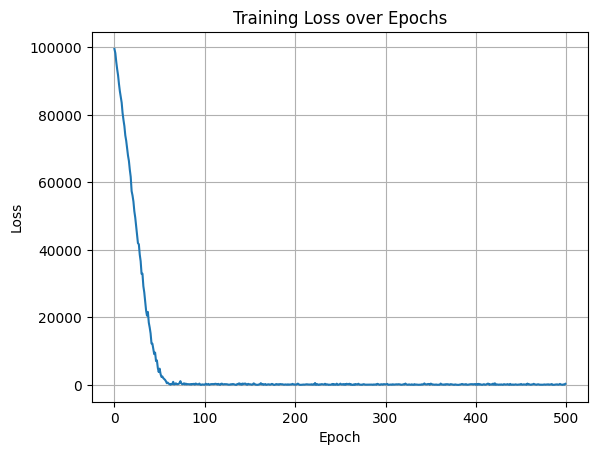

In [ ]:
import time
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt  # גרף בסוף

# Scheduler setup
scheduler_patience = 20
scheduler = ReduceLROnPlateau(regression_optimizer, mode='min', factor=0.5, patience=scheduler_patience, verbose=True)

# Early stopping setup (currently disabled)
# best_loss = float('inf')
# epochs_no_improve = 0
# early_stopping_patience = 20

num_epochs = 500
losses = []  # לאגור את הלוס לכל epoch

for epoch in range(num_epochs):
    start_time = time.time()

    regression_model.train()
    epoch_loss = 0

    for images, targets in regression_dataloader:
        images = images.to(device)
        targets = targets.to(device)

        regression_optimizer.zero_grad()
        outputs = regression_model(images)
        loss = regression_criterion(outputs, targets)
        loss.backward()
        regression_optimizer.step()
        epoch_loss += loss.item()

    epoch_loss /= len(regression_dataloader)
    losses.append(epoch_loss)  # שמירה לגרף

    # Evaluation
    regression_model.eval()
    all_preds = []
    all_targets = []
    with torch.no_grad():
        for images, targets in regression_dataloader:
            images = images.to(device)
            targets = targets.to(device)
            outputs = regression_model(images)
            all_preds.extend(outputs.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())

    r2 = r2_score(all_targets, all_preds)
    mae = mean_absolute_error(all_targets, all_preds)
    rmse = np.sqrt(mean_squared_error(all_targets, all_preds))
    epoch_time = time.time() - start_time

    print(f"Epoch: {epoch+1:3d} | Loss: {epoch_loss:.4f} | MAE: {mae:.2f} | RMSE: {rmse:.2f} | Time: {epoch_time:.2f} sec")
    current_lr = regression_optimizer.param_groups[0]['lr']
    print(f"Current LR: {current_lr:.6f}")

    # Scheduler step
    scheduler.step(epoch_loss)

    # Early stopping check (disabled)
    # if epoch_loss < best_loss:
    #     best_loss = epoch_loss
    #     epochs_no_improve = 0
    # else:
    #     epochs_no_improve += 1
    #     if epochs_no_improve >= early_stopping_patience:
    #         print("🛑 Early stopping triggered!")
    #         break

# Plot Loss per Epoch
plt.plot(losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss over Epochs")
plt.grid(True)
plt.show()


### Part 7: Evaluate Model and Plot Predictions vs Ground Truth



,filename,ground_truth,predicted
0,p63_1.tif,[206.0],[205.95308]
1,p63_2.tif,[328.0],[327.9685]
2,p63_3.tif,[416.0],[414.5168]
3,p63_4.tif,[266.0],[263.16306]
4,p63_5.tif,[324.0],[323.06006]


💾 Saved to: prediction_results.csv
R² Score: 0.9995


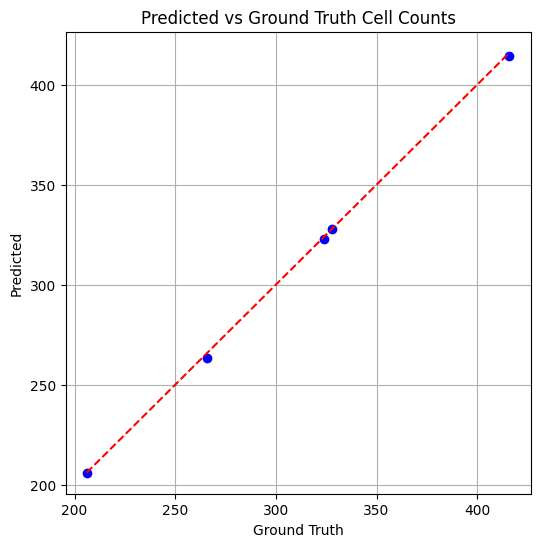

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
import pandas as pd

# יצירת רשימת שמות הקבצים המקבילה לתחזיות
file_names = original_files[:len(all_preds)]

# בניית טבלה
results_df = pd.DataFrame({
    "filename": file_names,
    "ground_truth": all_targets,
    "predicted": all_preds
})

# תצוגה
display(results_df)

# שמירה ל־CSV
results_df.to_csv("/content/drive/MyDrive/final project/prediction_results.csv", index=False)
print("💾 Saved to: prediction_results.csv")

regression_model.eval()
all_preds = []
all_targets = []

with torch.no_grad():
    for images, targets in regression_dataloader:
        images = images.to(device)
        targets = targets.to(device)

        outputs = regression_model(images)
        all_preds.extend(outputs.view(-1).cpu().tolist())
        all_targets.extend(targets.view(-1).cpu().tolist())


# Compute R² score
r2 = r2_score(all_targets, all_preds)
print(f"R² Score: {r2:.4f}")

# Plot predictions vs ground truth
plt.figure(figsize=(6,6))
plt.scatter(all_targets, all_preds, color='blue')
plt.plot([min(all_targets), max(all_targets)], [min(all_targets), max(all_targets)], 'r--')
plt.xlabel("Ground Truth")
plt.ylabel("Predicted")
plt.title("Predicted vs Ground Truth Cell Counts")
plt.grid(True)
plt.show()

### 📊 Part 7.1: Evaluate MAE and RMSE


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

mae = mean_absolute_error(all_targets, all_preds)
rmse = np.sqrt(mean_squared_error(all_targets, all_preds))

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")


MAE: 1.18
RMSE: 1.29


# **Predicting Expression levels**

## 🧩 PART 1 – Load Images and Masks


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import os
import numpy as np
import pandas as pd
from skimage.io import imread
from skimage.color import rgb2gray
from skimage.measure import regionprops
from PIL import Image
import torch
# Define paths
original_dir   = '/content/drive/MyDrive/final project/Part 3 - Cell Segmentation with Transfer Learning/data/original_images'
expression_dir = '/content/drive/MyDrive/final project/Part 3 - Cell Segmentation with Transfer Learning/data/stained images'
mask_dir       = '/content/drive/MyDrive/final project/Part 3 - Cell Segmentation with Transfer Learning/data/cellsam_predicted_mask'

image_files = sorted(os.listdir(original_dir))


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"✅ Using device: {device}")



✅ Using device: cuda


##🧩 PART 2 – Extract Cells and Expression Labels



In [ ]:
data = []

for fname in image_files:
    orig_path  = os.path.join(original_dir, fname)
    expr_path  = os.path.join(expression_dir, fname)
    mask_path  = os.path.join(mask_dir, fname.replace('.tif', '_mask.tif'))

    if not (os.path.exists(orig_path) and os.path.exists(expr_path) and os.path.exists(mask_path)):
        print(f"❌ Missing file for {fname}")
        continue

    orig_img = imread(orig_path)
    expr_img = rgb2gray(imread(expr_path)) if imread(expr_path).ndim == 3 else imread(expr_path)
    mask     = imread(mask_path)

    regions = regionprops(mask)
    print(f"📂 {fname} – Found {len(regions)} regions")

    for region in regions:
        if region.area < 50:
            continue
        minr, minc, maxr, maxc = region.bbox
        crop_img  = orig_img[minr:maxr, minc:maxc]
        crop_expr = expr_img[minr:maxr, minc:maxc]
        mask_crop = (mask[minr:maxr, minc:maxc] == region.label)

        if mask_crop.sum() == 0:
            continue

        expr_value = crop_expr[mask_crop].mean()
        data.append((crop_img, expr_value))




📂 p63_1.tif – Found 258 regions
📂 p63_2.tif – Found 325 regions
📂 p63_3.tif – Found 526 regions
📂 p63_4.tif – Found 429 regions
📂 p63_5.tif – Found 432 regions


##🧩 PART 3 – Prepare Dataset for PyTorch



In [ ]:
from torchvision import transforms
import torch
from torch.utils.data import Dataset, DataLoader

transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

class CellExpressionDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image, label = self.data[idx]
        image = transform(image)
        label = torch.tensor([label], dtype=torch.float)
        return image, label

expression_dataset = CellExpressionDataset(data)
expression_loader = DataLoader(expression_dataset, batch_size=16, shuffle=True)


##🧩 PART 4 – Define Regression Model (ResNet18)


In [ ]:
from torchvision.models import resnet18
import torch.nn as nn

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = resnet18(pretrained=False)
model.fc = nn.Sequential(
    nn.Dropout(0.3),
    nn.Linear(model.fc.in_features, 1)
)
model = model.to(device)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


## 🧩 PART 5 – Training Loop

In [ ]:
import torch.optim as optim
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)

losses = []
num_epochs = 200

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for images, labels in expression_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    total_loss /= len(expression_loader)
    losses.append(total_loss)
    print(f"Epoch {epoch+1}/{num_epochs} - Loss: {total_loss:.4f}")

    # 🧪 Evaluate on all training data
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in expression_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            all_preds.extend(outputs.view(-1).cpu().numpy())
            all_labels.extend(labels.view(-1).cpu().numpy())

    r2 = r2_score(all_labels, all_preds)
    mae = mean_absolute_error(all_labels, all_preds)
    rmse = np.sqrt(mean_squared_error(all_labels, all_preds))
    print(f"📊 R²: {r2:.4f} | MAE: {mae:.4f} | RMSE: {rmse:.4f}")


Epoch 1/200 - Loss: 0.4248
📊 R²: -6.0089 | MAE: 0.1693 | RMSE: 0.2924
Epoch 2/200 - Loss: 0.0547
📊 R²: -0.3602 | MAE: 0.0824 | RMSE: 0.1288
Epoch 3/200 - Loss: 0.0340
📊 R²: -0.5882 | MAE: 0.0770 | RMSE: 0.1392
Epoch 4/200 - Loss: 0.0247
📊 R²: -1.5285 | MAE: 0.1022 | RMSE: 0.1756
Epoch 5/200 - Loss: 0.0214
📊 R²: -0.1071 | MAE: 0.0739 | RMSE: 0.1162
Epoch 6/200 - Loss: 0.0162
📊 R²: -0.0118 | MAE: 0.0785 | RMSE: 0.1111
Epoch 7/200 - Loss: 0.0119
📊 R²: 0.3911 | MAE: 0.0562 | RMSE: 0.0862
Epoch 8/200 - Loss: 0.0106
📊 R²: 0.3518 | MAE: 0.0557 | RMSE: 0.0889
Epoch 9/200 - Loss: 0.0094
📊 R²: 0.3199 | MAE: 0.0662 | RMSE: 0.0911
Epoch 10/200 - Loss: 0.0104
📊 R²: -1.2499 | MAE: 0.1124 | RMSE: 0.1657
Epoch 11/200 - Loss: 0.0100
📊 R²: 0.5959 | MAE: 0.0498 | RMSE: 0.0702
Epoch 12/200 - Loss: 0.0080


KeyboardInterrupt: 

##🧩 PART 6 – Plot Loss

In [ ]:
plt.plot(losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss – Expression Prediction")
plt.grid(True)
plt.show()
